The term "chemical reaction" is another name for the transformation of molecules—the breaking and forming of bonds. These reactions are characterized by an energy barrier that determines the likelihood of the reaction occurring. The energy landscapes formed by these particles are key to understanding how chemical reactions take place at the deepest possible level.

Here, we will explore how quantum computers can be used to calculate equilibrium bond lengths, activation energy barriers, and reaction rates.

In [25]:
import numpy as np

from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit

from qiskit_algorithms import NumPyMinimumEigensolver, VQE
from qiskit_algorithms.optimizers import SLSQP

from qiskit.primitives import Estimator

In [26]:
solver = GroundStateEigensolver(
    JordanWignerMapper(),
    NumPyMinimumEigensolver(),
)

In [27]:
# atomic symbols defining the molecule
symbols = ['H', 'H']

# list to store energies
energies = []

# set up a loop to change bond length
r_range = np.arange(0.3, 5.0, 0.10)

coordinates = np.array([[0.0, 0.0, 0.0], [0.0, 0.0, 0.5]])

In [28]:
mapper = JordanWignerMapper()
numpy_solver = NumPyMinimumEigensolver()

In [29]:
for r in r_range:
    atom = f'{symbols[0]} 0 0 0; {symbols[1]} 0 0 {r}'

    driver = PySCFDriver(
        atom=atom,
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    es_problem = driver.run()

    ansatz = UCCSD(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
        ),
    )

    vqe_solver = VQE(Estimator(), ansatz, SLSQP())
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters

    calc = GroundStateEigensolver(mapper, vqe_solver)
    res = calc.solve(es_problem)

    energy = res.total_energies[0]

    energies.append(energy)

/tmp/ipykernel_5002/428634595.py:25: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE(Estimator(), ansatz, SLSQP())


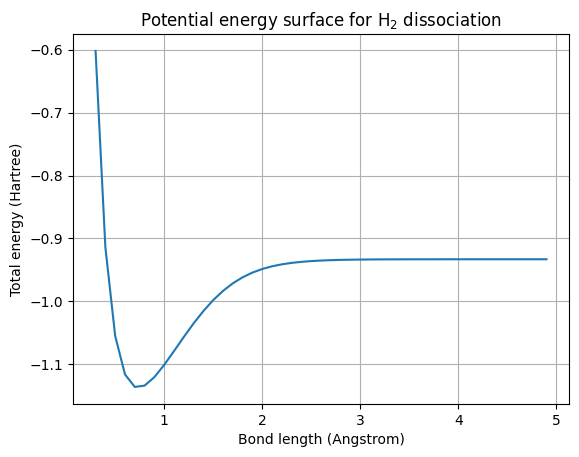

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(r_range, energies)

ax.set(
    xlabel="Bond length (Angstrom)",
    ylabel="Total energy (Hartree)",
    title="Potential energy surface for H$_2$ dissociation",
)
ax.grid()
plt.show()

This is the potential energy surface for the dissociation of a hydrogen molecule into two hydrogen atoms. Here, the equilibrium bond length is where the diatomic distance minimizes the energy. We can clearly see this in the graph, but let's obtain these values:


In [31]:
# equilibrium energy
e_eq = min(energies)
# energy when atoms are far apart
e_dis = energies[-1]

# Bond dissociation energy
bond_energy = e_dis - e_eq

# Equilibrium bond length
idx = energies.index(e_eq)
bond_length = r_range[idx]

print(f"The equilibrium bond length is {bond_length:.1f} Bohrs")
print(f"The bond dissociation energy is {bond_energy:.6f} Hartrees")

The equilibrium bond length is 0.7 Bohrs
The bond dissociation energy is 0.203026 Hartrees
